In [113]:
import yfinance as yf
import pandas as pd
from datetime import date, timedelta, datetime

vix = yf.download('^VIX', start='2010-01-31', end='2022-03-01', interval='1d', prepost=False, threads=True)['Close']
nvda = yf.download('NVDA', start='2010-01-31', end='2022-03-01', interval='1d', prepost=False, threads=True)['Close']
sp500 = yf.download('^GSPC', start='2010-01-31', end='2022-03-01', interval='1d', prepost=False, threads=True)['Close']
sp500 = sp500.resample('1Y').last().pct_change().dropna().mean()
nvidia_beta = yf.Ticker('NVDA').info['beta']
rf = yf.download('^TNX', start='2010-01-31', end='2022-03-01', interval='1d', prepost=False, threads=True)['Close'] / 100

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [114]:
# Nvidia earnings are always released after market close, so we take the closing price of that day
NVDA_file_dates = [date(2010, 2, 17), date(2011, 2, 16), date(2012, 2, 15), date(2013, 2, 13), date(2014, 2, 12), date(2015, 2, 11), date(2016, 2, 17), date(2017, 2, 9), date(2018, 2, 8), date(2019, 2, 14), date(2020, 2, 13), date(2021, 2, 24), date(2022, 2, 16)]
NVDA_file_dates = list(map(pd.to_datetime, NVDA_file_dates))

In [169]:
def yearly_returns_FY(df, FYs):
    df = df[df.index.isin(FYs)]
    df = df.pct_change()
    return df.dropna()

def yearly_slice(df, FYs):
    df = df[df.index.isin(FYs)]
    return df.dropna()

def ewma(df, d=0.94):
    return df.pct_change().ewm(alpha=1-d, adjust=True).mean()

def capm(beta, sp500, rf):
    return beta * (sp500 - rf) + rf

# Ground truths
nvda_yearly_closes = nvda[nvda.index.isin(NVDA_file_dates)]
nvda_yearly_returns = yearly_returns_FY(nvda, NVDA_file_dates)
vix_yearly_mean = vix.groupby(pd.Grouper(freq='1Y')).mean()

# Features
nvda_yearly_ewma_returns = yearly_slice(ewma(nvda, d=0.99), NVDA_file_dates) * 252.03  # assuming 1 year 252.03 trading days (on avg), since ewma is daily so return needs to be annualized
nvidia_capm = yearly_slice(capm(nvidia_beta, sp500, rf), NVDA_file_dates)

In [170]:
# Align features, start 2012-02-15
# for CAPM and EWMA, value at 2012 feb will predict return from 2012 feb to 2013 feb
nvidia_capm = nvidia_capm[2:]
nvda_yearly_ewma_returns = nvda_yearly_ewma_returns[2:]

# Predicting returns 1 year ahead so yearly_returns should start with return from 2012 feb to 2013 feb, which is the value at 2013 feb
nvda_yearly_returns = nvda_yearly_returns[2:]
# for dcf and comps, FY 2012 implied price should predict the price on 2013 feb (end of FY 2013), so the implied upside is calculated from 2012 feb.
DCF = [9.26, 11.88, 22.00, 25.58, 36.79, 40.82, 60.41, 75.05, 94.05, 115.53, 135.04]
nvda_yearly_closes = nvda_yearly_closes[2:]
DCF_implied_upside = (DCF / nvda_yearly_closes) - 1

Comps = [4.59, 4.25, 3.48, 5.30, 4.58, 12.30, 35.33, 51.43, 12.86, 45.04, 120.83]
Comps_implied_upside = (Comps / nvda_yearly_closes) - 1

# Align VIX
vix_yearly_mean = vix_yearly_mean[2:]
assert len(nvidia_capm) == len(nvda_yearly_ewma_returns) == len(DCF) == len(Comps) == len(vix_yearly_mean) == len(nvda_yearly_returns) + 1

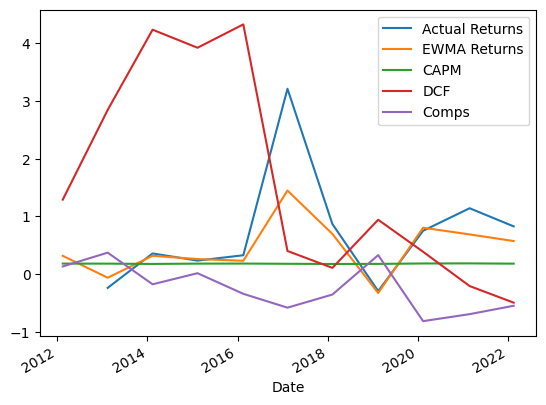

In [175]:
import matplotlib.pyplot as plt
nvda_yearly_returns.plot()
nvda_yearly_ewma_returns.plot()
nvidia_capm.plot()
DCF_implied_upside.plot()
Comps_implied_upside.plot()
plt.legend(['Actual Returns', 'EWMA Returns', 'CAPM', 'DCF', 'Comps'])

In [184]:
# Regression
import numpy as np
from sklearn.linear_model import LinearRegression

vix_yearly_mean = vix_yearly_mean/100  # scale down to prevent very small numbers
features = pd.DataFrame({'EWMA': np.exp(-vix_yearly_mean) * nvda_yearly_ewma_returns.values, 'CAPM': np.exp(-vix_yearly_mean) * nvidia_capm.values, 'DCF': np.exp(-vix_yearly_mean) * DCF_implied_upside.values, 'Comps': np.exp(-vix_yearly_mean) * Comps_implied_upside.values})
target = nvda_yearly_returns


In [189]:
np.exp(-vix_yearly_mean/100)

Date
2012-12-31    0.836952
2013-12-31    0.867360
2014-12-31    0.867845
2015-12-31    0.846419
2016-12-31    0.853631
2017-12-31    0.895026
2018-12-31    0.846709
2019-12-31    0.857376
2020-12-31    0.746386
2021-12-31    0.821549
2022-12-31    0.783239
Freq: A-DEC, Name: Close, dtype: float64

In [187]:
vix_yearly_mean/100

Date
2012-12-31    0.177989
2013-12-31    0.142301
2014-12-31    0.141742
2015-12-31    0.166741
2016-12-31    0.158256
2017-12-31    0.110902
2018-12-31    0.166398
2019-12-31    0.153879
2020-12-31    0.292513
2021-12-31    0.196564
2022-12-31    0.244318
Freq: A-DEC, Name: Close, dtype: float64